# Practice: Head Pose Detector

¡Hola! Vamos de lleno con la Practice de esta semana. 

El objetivo es detectar dónde está mirando una persona fijándose en una foto de su cara.

Para ello, utilizaremos el Dataset que se puede encontrar en http://crowley-coutaz.fr/HeadPoseDataSet/HeadPoseImageDatabase.tar.gz

### 0. Importación de librerías

Como siempre, recuerda importar las librerías que vayas a necesitar. Te hemos dejado las que podrían serte necesarias para este caso.

Es importante que si no sabes para qué puede valer una librería, hagas una búsqueda y entiendas por qué ha sido importada. Es bastante probable que así puedas identificar mejor las que deberás usar en los siguientes pasos.

In [1]:
#--------------------Librerias--------------------

# Añadir las que sean necesarias

import glob
import os 
import re
import requests

from datetime import datetime 
import matplotlib.pyplot as plt
import numpy as np  # asarray

from tensorflow import keras
from pprint import pprint
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

### 1. Descarga de Dataset: Head Pose Image Database (Gourier, Hall, & Crowley, 2004)

Lo siguiente es descargar el dataset de http://crowley-coutaz.fr/HeadPoseDataSet/HeadPoseImageDatabase.tar.gz y estructurar los datos para dejarlos listos para su uso (descompresión del archivo tar.gz, creación de variables, tratamiento de expresiones regulares ...).

La información relevante a la construcción del dataset se puede encontrar en http://crowley-coutaz.fr/Head%20Pose%20Image%20Database.html

In [2]:
TARGET_FOLDER = "content/drive/MyDrive/satAI/week_03/challenge"
DATA_FOLDER = "./data"

IMG_SIZE = (200,200)  # Default MobileNet is 224 but it also accepts 200
STATE= 42

In [3]:
from google.colab import drive
import sys

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
sys.path.append("/content/drive/MyDrive/satAI/week_03/challenge/module/")

In [5]:
from module.FetchData     import get_data, parse_txtfile, construct_targetvalues
from module.TransformData import img_df, transform_X, transform_Y

##### 1.1 Descarga y tratamiento como archivo

In [6]:
filename = get_data()

##### 1.2 Descomprime del archivo tar.gz, usando el Linux que hay debajo de Jupyter Notebook, mediante el comando tar

In [7]:
!mkdir "$DATA_FOLDER"
!tar xvzf "$filename" --directory "$DATA_FOLDER/"

Streaming output truncated to the last 5000 lines.
Person02/person02258+15-15.txt
Person02/person02143+0-45.txt
Person02/person02191+60+90.jpg
Person02/person02224-30+60.jpg
Person02/person02218-30-30.jpg
Person02/person02243+0-45.txt
Person02/person02123-30+45.txt
Person02/person02146+0+0.jpg
Person02/person02172+30+0.jpg
Person02/person02149+0+45.jpg
Person02/person02163+15+60.jpg
Person02/person02183+60-30.txt
Person02/person02212-60+75.jpg
Person02/person02119-30-15.jpg
Person02/person02161+15+30.txt
Person02/person02281+60-60.jpg
Person02/person02166+30-90.jpg
Person02/person02230-15-45.txt
Person02/person02206-60-15.txt
Person02/person02170+30-30.jpg
Person02/person02206-60-15.jpg
Person02/person02202-60-75.jpg
Person02/person02268+30-60.txt
Person02/person02106-60-15.txt
Person02/person02228-15-75.jpg
Person02/person02101-60-90.txt
Person02/person02219-30-15.txt
Person02/person02225-30+75.txt
Person02/person02157+15-30.jpg
Person02/person02275+30+45.txt
Person02/person02277+30+7

> el !tar crea un una estructura de carpetas con toda las imgs

#### Formato del archivo:

Recordad que en el enlace de información se describe cómo está guardada la información, estando en cada archivo de la imagen los ángulos de inclinación y giro (tilt,pan) y las coordenadas de la cara (x,y), altura y anchura (h,w) dentro del archivo.

##### 1.3 Tratamiento de las expresiones regulares de los títulos de las imágenes para conseguir las caracteristicas

Os dejamos esta función para que, dado el path de una imagen, pueda transformarla a un tamaño más trabajable.

In [8]:
img_dict = construct_targetvalues()

{'id': ('05', '2', '68'),
 'values': {'H': '96',
            'P': '-60',
            'T': '+30',
            'W': '100',
            'X': '208',
            'Y': '93'}}


##### 1.4 Separado en X (datos) e Y (a predecir) y su normalización

In [9]:
# Como las imagenes XX2XX y XX1XX son casi las mismas, 
# voy a probar con quitarme el segundo set

"""
img_dict = {k:v for k, v in img_dict.items() 
            if v['id'][1] != '2'
}
"""

"\nimg_dict = {k:v for k, v in img_dict.items() \n            if v['id'][1] != '2'\n}\n"

In [10]:
%timeit

X = transform_X(datadict = img_dict, img_size=IMG_SIZE)
Y = transform_Y(datadict = img_dict)

X as <class 'numpy.ndarray'> with shape (2790, 200, 200, 3)
Y as <class 'numpy.ndarray'> with shape (2790, 6)


La iteración sobre todas las carpetas devuelve un diccionario en el que el mapa más profundo guarda los vectores target de la predicción más las id,

##### 1.5 Split de conjuntos finales de x_train, y_train, x_test y y_test

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.25, 
    random_state=STATE
)

X_train, X_validation, Y_train, Y_validation = train_test_split(
    X_train, Y_train, 
    test_size=0.25, 
    random_state=STATE
)

In [12]:
display(f"TRAIN SHAPES: X:{X_train.shape}  Y:{Y_train.shape}")
display(f"TEST  SHAPES: X:{X_test.shape}  Y:{Y_test.shape}")
display(f"VALD  SHAPES: X:{X_validation.shape}  Y:{Y_validation.shape}")

'TRAIN SHAPES: X:(1569, 200, 200, 3)  Y:(1569, 6)'

'TEST  SHAPES: X:(698, 200, 200, 3)  Y:(698, 6)'

'VALD  SHAPES: X:(523, 200, 200, 3)  Y:(523, 6)'

In [13]:
print(f"X as {type(X_train)} with shape {X_train.shape}")
print(f"Y as {type(Y_train)} with shape {Y_train.shape}")

X as <class 'numpy.ndarray'> with shape (1569, 200, 200, 3)
Y as <class 'numpy.ndarray'> with shape (1569, 6)


----

### 2 Importado de red neuronal MobileNet sin incluir la última capa

El objetivo aquí es importar la red neuronal MobileNet (una arquitectura que ha demostrado ser bastante eficiente para este problema) excluyendo la última capa. Con ello, descartaremos la última capa, para posteriormente crearla nosotros y concatenar las dos partes.

##### 2.1 Importar la red de Keras sin la última capa

In [14]:
from keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers  import Adam
from tensorflow.keras.models      import Sequential
from tensorflow.keras.layers      import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, Input
from tensorflow.keras.losses      import CosineSimilarity
from tensorflow.keras.metrics     import RootMeanSquaredError

In [15]:
N_CLASSES = Y.shape[-1]

##### 2.2 Crear nuestra última capa

##### 2.3 Juntar la red y la capa

##### 2.4 Compilar (elegir optimizador, funcion de perdida(loss) y métrica de error)

In [ ]:
from module.Model import get_model

In [18]:
train_params = {
    "n_classes": N_CLASSES,
    "input_shape": IMG_SIZE+(3,),
    "trainable_index": None,    # Better models when mobilenet left untouched
    "learning_rate": 0.0005,    # Default 0.01
    "dropout": 0.25,
    "momentum": 0.985  # Default
}

model = get_model(train_params)

17235968/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 6, 6, 1024)       3228864   
 nal)                                                            
                                                                 
 top_layer (Sequential)      (None, 6)                 37604     
                                                                 
Total params: 3,266,468
Trainable params: 35,556
Non-trainable params: 3,230,912
_________________________________________________________________


##### 2.5 Entrenar la red que hemos importado y manipulado con el dataset que hemos tratado

In [19]:
#--------------------Entrenamiento de nuestra red personalizada--------------------
# Un precioso fit() y a esperar. Unas 10 épocas deberian dar un resultado decente

history=model.fit(
    X_train, Y_train, 
    validation_data=(X_test, Y_test), 
    epochs=30, 
    verbose=1
)

# TODO: callbacks

Epoch 1/30
50/50 [==============================] - 70s 1s/step - loss: -0.7163 - root_mean_squared_error: 0.9591 - val_loss: -0.9214 - val_root_mean_squared_error: 0.7406
Epoch 2/30
50/50 [==============================] - 61s 1s/step - loss: -0.9459 - root_mean_squared_error: 0.6683 - val_loss: -0.9302 - val_root_mean_squared_error: 0.6062
Epoch 3/30
50/50 [==============================] - 60s 1s/step - loss: -0.9571 - root_mean_squared_error: 0.5958 - val_loss: -0.9346 - val_root_mean_squared_error: 0.5806
Epoch 4/30
50/50 [==============================] - 60s 1s/step - loss: -0.9638 - root_mean_squared_error: 0.5568 - val_loss: -0.9420 - val_root_mean_squared_error: 0.5606
Epoch 5/30
50/50 [==============================] - 58s 1s/step - loss: -0.9680 - root_mean_squared_error: 0.5401 - val_loss: -0.9495 - val_root_mean_squared_error: 0.5472
Epoch 6/30
50/50 [==============================] - 55s 1s/step - loss: -0.9709 - root_mean_squared_error: 0.5225 - val_loss: -0.9582 - val_

#####2.5 Evaluación del modelo: ploteado de su historia

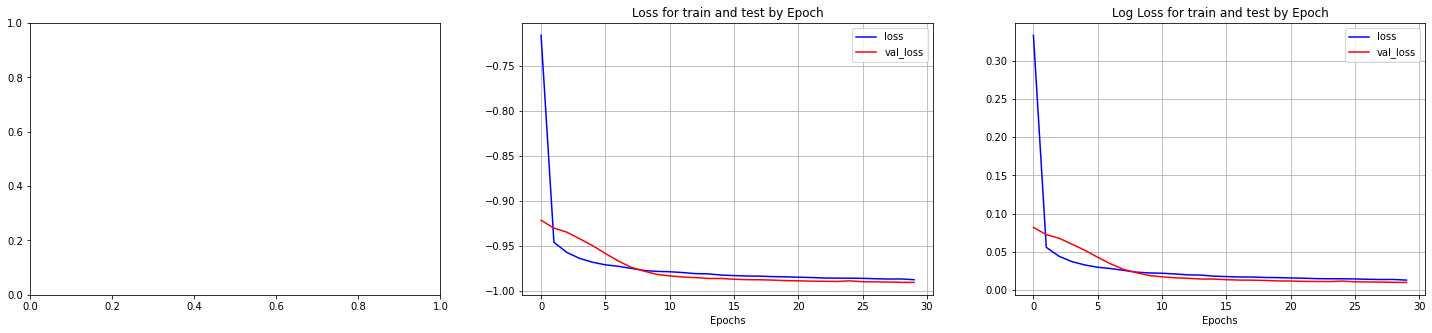

In [31]:
import pandas as pd
metrics = pd.DataFrame(history.history)
get_cols_by_str = lambda s, df: df.columns[df.columns.str.contains(s)]

##############################
plot_args = {
    'color': ['blue','red'],
    'grid' : True,
    'xlabel': 'Epochs'
}

f, ax = plt.subplots(ncols = 3, figsize = (25,5))

metrics[get_cols_by_str(s='loss', df=metrics)].plot.line(ax = ax[1], title='Loss for train and test by Epoch', **plot_args)
metrics[get_cols_by_str(s='loss', df=metrics)].apply(lambda d: -np.log(np.abs(d))).plot.line(ax = ax[2], title='Log Loss for train and test by Epoch', **plot_args)
#metrics[get_cols_by_str(s='accu', df=metrics)].plot.line(ax = ax[0], title='Accuracy for train and test by Epoch', **plot_args)

plt.show()

In [21]:
def plot_model_history(model_history):
    """ Prints both the accuracy and the loss of the training history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))


    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['root_mean_squared_error'])+1),model_history.history['root_mean_squared_error'])
    axs[0].plot(range(1,len(model_history.history['val_root_mean_squared_error'])+1),model_history.history['val_root_mean_squared_error'])
    axs[0].set_title('Model RMSE')
    axs[0].set_ylabel('RMSE')
    axs[0].set_xlabel('Epoch')

    axs[0].set_xticks(np.arange(1,len(model_history.history['root_mean_squared_error'])+1),len(model_history.history['root_mean_squared_error'])/10)
    axs[0].legend(['train', 'val'], loc='best')

    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])

    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')

    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


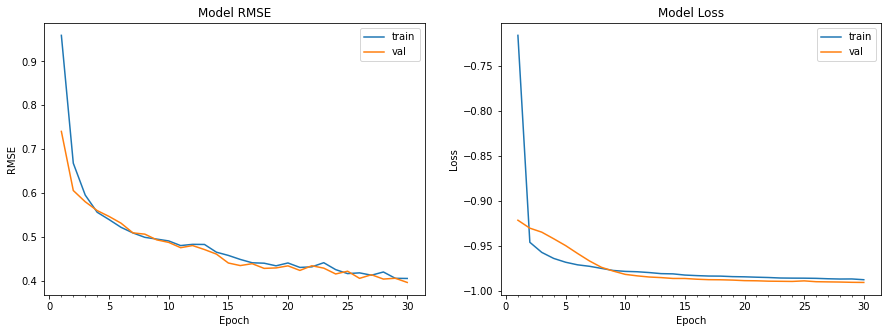

In [22]:
plot_model_history(history)

##### 2.6 Visualizar un diagrama de correlación entre los valores predichos y los valores que debieran ser (usando por ejemplo el RMSE o R2 dado por sklearn)

In [24]:
# resultados
model.evaluate(X_validation, Y_validation)

17/17 [==============================] - 13s 753ms/step - loss: -0.9910 - root_mean_squared_error: 0.4006


[-0.9910301566123962, 0.4005686044692993]

In [26]:
def save_model(model):
    """Save the results of a model."""

    id = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
    model.save(f"huff_model_{id}.h5")

In [32]:
save_model(model=model)

##### 2.6 Visualización de metricas
# TODO